# Bitcoin Price Prediction 

Maiah Pardo<br/>
August 20, 2021

This project is an attempt at Bitcoin stock price prediction using a Recurrent neural network model. I use data gathered from https://finance.yahoo.com/quote/BTC-USD/history/ to train my neural network.

In [ ]:
%matplotlib inline

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
import pandas as pd
import numpy as np
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1JbrxeSqazKn-WjizVDPG9VvhkXVG--D-'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('BTC-USD.csv')

In [ ]:
# Create pandas dataframe
data = pd.read_csv('BTC-USD.csv')

In [ ]:
# Plot data.head()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


Plotting the bitcoin price. Here, let's plot price vs days after September 15, 2014, the start date of this dataset. Day "0" indicates September 15, 2014.

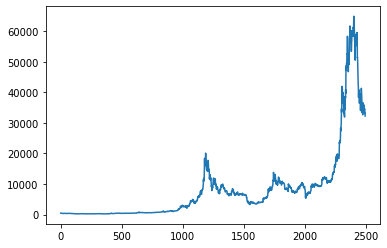

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2495,2495), y = data['High'].values.reshape(-1))


Here, let's again plot bitcoin price vs. days, but with dates in place of day 0, 1, 2, etc.

[Text(0, 0, '2014-09-17'),
 Text(0, 0, '2015-04-05'),
 Text(0, 0, '2015-10-22'),
 Text(0, 0, '2016-05-09'),
 Text(0, 0, '2016-11-25'),
 Text(0, 0, '2017-06-13'),
 Text(0, 0, '2017-12-30'),
 Text(0, 0, '2018-07-18'),
 Text(0, 0, '2019-02-03'),
 Text(0, 0, '2019-08-22'),
 Text(0, 0, '2020-03-09'),
 Text(0, 0, '2020-09-25'),
 Text(0, 0, '2021-04-13')]

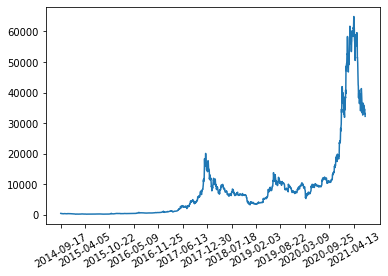

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2495,2495), y = data['High'].values.reshape(-1))
#g.map(plt.plot, "a", "v", marker="o")
g.set(xticks=np.arange(0,2500,200))
g.set_xticklabels(rotation=30, labels = data['Date'][0::200])

Let's preprocess the data in order to train a recurrent neural network. There 5 columns: "Date", "Open", "High", "Low", "Close", "Adjusted Close", and "Volume". I will only use the High column data.

In [ ]:
# removing nan's from the data base

# determine if any values are null (nan)
print("Are there nan's in data:", data.isnull().values.any())

# how many values are null
#print(data.isnull().sum())

# remove all nan rows
data = data.dropna()

# check all nans are gone
print("Are there nan's in data:", data.isnull().values.any())

# Create a dataframe that only contains High Column.
# Hint: it may be helpful to now cast your pruned dataframe to a numpy array.

data_high = np.array(data['High'])
#print(list(data_high))


Are there nan's in data: True
Are there nan's in data: False


Here I use [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn to scale the data for the analysis. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# scale data_high to a number between 0 and 1 
# the data has a single feature (column) so we must reshape our data to use minmaxscaler
data_high = data_high.reshape(-1, 1)

# create the scaler
scaler = MinMaxScaler() 

# normalize the data using the scaler
data_normalized = scaler.fit_transform(data_high) 

#print(data_normalized)
#data_normalized

Let's implement a simple autoregressive recurrent neural network using the standard tensorflow RNN architectures. An autoregressive model originates from the literature on time-series models where observations from the previous time-steps are used to predict the value at the current time step. To implemement an autoregressive model, we will simply augment the data so that "time_steps" number of previous days are fed to the model at the current time step in order to form a prediction. 

In [ ]:

def create_dataset(dataset, time_steps=1):
    """
    Generate a dataset where the time series X[n] contains the readings for the 'time_step' previous days 
    and y contains the price for today.
    args:
    dataset: numpy array, the data
    time_steps: the number of previous days to feed to RNN

    returns:
    tuple: a dataset with x[i] containing 'time_step' number of previous prices, target price for x[i]
    """
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps)]
        dataX.append(a)
        dataY.append(dataset[i + time_steps])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Choose the number of time steps that the model "looks back"
look_back_days = 50 

# Produce the dataset based on the number of days the model will look back
X, y = create_dataset(data_normalized, look_back_days)

'''
print("X is:", X) # X contains 50 values for 50 time steps
print("y is:", y) # y contains the last value of every inner X element

print("X shape is:", X.shape)
print("y shape is:", y.shape)
'''

'\nprint("X is:", X) # X contains 50 values for 50 time steps\nprint("y is:", y) # y contains the last value of every inner X element\n\nprint("X shape is:", X.shape)\nprint("y shape is:", y.shape)\n'

In [ ]:
# Checking the shape of the dataset
print(X.shape, y.shape)

(2440, 50, 1) (2440, 1)


Splitting the data into train and test sets. Using 80% for training and 20% for testing. Note: The data must be split in time (the begining 80% of the days from start date will be the training data and the remaining 20% will be test data).

In [ ]:
num_train_data = np.round(.80 * X.shape[0])  # need beginning 80% of data for training
num_test_data = X.shape[0] - num_train_data  # need last 20% of data for testing

print("Number of training data points:", num_train_data)
print("Number of test data points:", num_test_data)


X_train = []
y_train = [] 
X_test = []
y_test = []

for i in range(X.shape[0]):
  if i < int(num_train_data):
    X_train.append(list(X[i]))
    y_train.append(list(y[i]))
  else:
    X_test.append(list(X[i]))
    y_test.append(list(y[i]))


y_train = np.array(y_train) # save as numpy array
X_train = np.array(X_train)
y_test = np.array(y_test) 
X_test = np.array(X_test)

Number of training data points: 1952.0
Number of test data points: 488.0


Data partitions must be reshaped for the model.

In [ ]:
# Reshape input to be [samples, time steps, features].
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

#print(X_train.shape)
#print(X_test.shape)

In this part I create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on the training data. I use mean squared error as my model's metric. I then plot training and validation loss.

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, LSTM
import tensorflow as tf

# Build model

input_layer = Input(shape=(1, look_back_days))

x = LSTM(units=10, activation='relu')(input_layer) # 1-20 units
x = Dense(1, activation='linear')(x) 

model = Model(input_layer, x)
model.summary()

loss = 'mean_squared_error' 
opt = 'adam'
metrics = 'mse' # illustrates how models prediction are close to actual labels

model.compile(loss=loss,
              optimizer=opt,
              metrics=[metrics])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 50)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                2440      
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 2,451
Trainable params: 2,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batchsize = 256 
epochs =  50 

# Fit model
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=False)


Epoch 1/50
7/7 [==============================] - 4s 39ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 2/50
7/7 [==============================] - 0s 7ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 3/50
7/7 [==============================] - 0s 8ms/step - loss: 9.5624e-04 - mse: 9.5624e-04 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 4/50
7/7 [==============================] - 0s 7ms/step - loss: 6.9369e-04 - mse: 6.9369e-04 - val_loss: 9.1418e-04 - val_mse: 9.1418e-04
Epoch 5/50
7/7 [==============================] - 0s 8ms/step - loss: 6.1012e-04 - mse: 6.1012e-04 - val_loss: 5.6109e-04 - val_mse: 5.6109e-04
Epoch 6/50
7/7 [==============================] - 0s 8ms/step - loss: 5.6464e-04 - mse: 5.6464e-04 - val_loss: 4.4918e-04 - val_mse: 4.4918e-04
Epoch 7/50
7/7 [==============================] - 0s 7ms/step - loss: 5.0800e-04 - mse: 5.0800e-04 - val_loss: 4.3592e-04 - val_mse: 4.3592e-04
Epoch 8/50
7/7 [===============

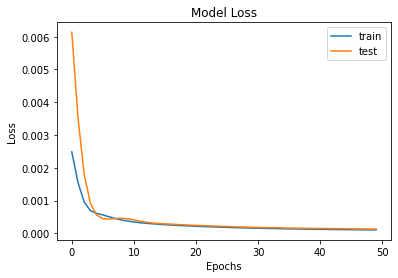

In [ ]:
# Plot the Model loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# Looking at the Predictions
Now I will show my model's performance on the test set by plotting the model's prediction for Bitcoin Price along with the actual test set prices. 

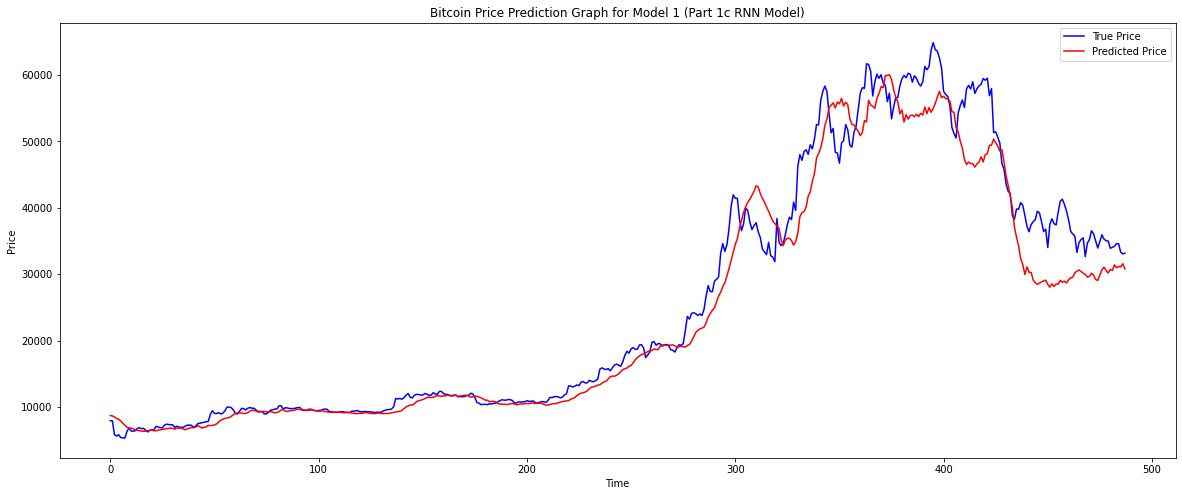

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting


denormalized_y_test = scaler.inverse_transform(y_test) # denormalize the actual y values
#print(denormalized_y)
y_pred = model.predict(X_test)

denormalized_y_pred = scaler.inverse_transform(y_pred)
#print(denormalized_y_pred)


# Plot Model 1

plt.figure(figsize=(20,8))
plt.plot(denormalized_y_test, color = 'blue', label = 'True Price')
plt.plot(denormalized_y_pred, color = 'red', label = 'Predicted Price')
plt.title('Bitcoin Price Prediction Graph for Model 1 (Part 1c RNN Model)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


print("\n\n\n")


Some analysis:<br/>

The Model seems to provide a good fit to the true data points. When I changed look back days in small increments (from 50 to 60, for example), there was not a huge obvious difference in the performance based on predictions. If I changed the look back days to much larger or much smaller numbers (150 or 5, for example), the model did not seem to predict prices as well.